In [ ]:
pip install path

In [ ]:
pip install statsmodels

In [ ]:
!pip install xgboost

In [ ]:
pip install abess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import time
from sklearn.metrics import roc_auc_score, r2_score
from collections import Counter
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import path
# import shap
import scipy
# import mrmr
from scipy.stats import pearsonr
from scipy.interpolate import UnivariateSpline
from scipy import stats
from sklearn import tree
from matplotlib.figure import Figure
import copy
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_squared_error
from abess import LinearRegression as best_subset_linreg

from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
# csv_path = os.getcwd()
csv_path = '/content/drive/MyDrive/hiv_dyspnea'

In [ ]:
# reading shape features file
important_features_shape_df = pd.read_csv(f'{csv_path}/vol_pyrads_3d_fractals_2d.csv')
important_features_shape_df.drop(columns=['Unnamed: 0', 'dyspnea'],inplace=True)
important_features_shape_df.head()

,patient_id,mean_original_shape_MinorAxisLength,max_original_shape_LeastAxisLength,min_original_shape_SurfaceArea,median_original_shape_Sphericity,median_original_shape_Maximum2DDiameterSlice,mean_original_shape_Maximum2DDiameterSlice,max_original_shape_Maximum2DDiameterSlice,es_val_original_shape_LeastAxisLength,snr_original_shape_Sphericity,...,lv_avg_smoothness_x,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y,lvmc_std_average_radial_ratio_y,lv_std_compactness_y,lvmc_avg_convexity_y,lv_avg_convexity_y,lvmc_avg_Hausdorff_Dimension_y,lv_avg_smoothness_y,pkvo2
0,101B,49.888415,47.814915,8573.415937,0.646279,66.520226,70.057204,88.737323,31.718557,17.449653,...,12.216862,0.013599,0.033473,0.064625,0.833340,0.963762,0.970200,0.991932,9.265517,64.0
1,103,54.103186,53.529400,15015.290737,0.751866,63.778096,62.102553,69.161044,43.574070,29.525190,...,16.547498,0.041558,0.057375,0.013719,0.242789,0.960596,0.967903,1.149487,12.410846,43.4
2,105B,54.406042,57.459717,16375.634482,0.745915,65.020076,64.873965,75.104094,46.901717,69.833563,...,16.777491,0.011419,0.021140,0.016302,0.339924,0.959437,0.965981,1.072997,13.201732,63.1
3,109,45.351699,47.679752,7851.744628,0.728897,52.572866,54.194956,63.948832,29.664223,28.524420,...,13.346112,0.020674,0.033041,0.024591,0.898496,0.963960,0.971693,1.010903,9.030605,44.0
4,113B,37.621807,42.053038,6754.987774,0.642737,51.020452,48.205548,58.754255,26.018235,24.363056,...,10.848970,0.022662,0.045689,0.044471,1.464580,0.967900,0.987050,1.024183,5.735172,60.0


In [ ]:
# filtering out fractal features
fractal_slope_features = [feat for feat in important_features_shape_df.columns.values if 'slope' in feat]
fractal_slope_features

[]

In [ ]:
# filtering out fractal features
fractal_intercept_features = [feat for feat in important_features_shape_df.columns.values if 'intercept' in feat]
fractal_intercept_features

[]

In [ ]:
# dropping fractal features since they depend on resolution
important_features_shape_df.drop(columns=fractal_slope_features,inplace=True)

In [ ]:
# extracting numerical columns for scaling
numerical_columns = list(important_features_shape_df.columns.values)
numerical_columns.remove('patient_id')
numerical_columns.remove('pkvo2')

In [ ]:
# scaling numerical columns
important_features_shape_df_scaled = important_features_shape_df.copy(deep=True)
important_features_shape_df_scaled[numerical_columns] = scaler.fit_transform(important_features_shape_df[numerical_columns])
important_features_shape_df_scaled.reset_index(inplace=True, drop=True)
important_features_shape_df_scaled.head()

,patient_id,mean_original_shape_MinorAxisLength,max_original_shape_LeastAxisLength,min_original_shape_SurfaceArea,median_original_shape_Sphericity,median_original_shape_Maximum2DDiameterSlice,mean_original_shape_Maximum2DDiameterSlice,max_original_shape_Maximum2DDiameterSlice,es_val_original_shape_LeastAxisLength,snr_original_shape_Sphericity,...,lv_avg_smoothness_x,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y,lvmc_std_average_radial_ratio_y,lv_std_compactness_y,lvmc_avg_convexity_y,lv_avg_convexity_y,lvmc_avg_Hausdorff_Dimension_y,lv_avg_smoothness_y,pkvo2
0,101B,0.680097,0.477322,0.322607,0.023530,0.841127,1.000000,1.000000,0.343199,0.009091,...,0.136393,0.148022,0.240439,1.000000,0.292527,0.430914,0.446254,0.000000,0.356866,64.0
1,103,0.879774,0.762901,0.881894,0.725116,0.740580,0.692493,0.468996,0.856051,0.126506,...,0.568204,0.603243,0.549118,0.085644,0.000000,0.205140,0.370768,0.823346,0.674812,43.4
2,105B,0.894122,0.959317,1.000000,0.685575,0.786120,0.799629,0.630200,1.000000,0.518440,...,0.591136,0.112519,0.081175,0.132044,0.048116,0.122505,0.307613,0.423628,0.754759,63.1
3,109,0.465167,0.470568,0.259951,0.572492,0.329714,0.386805,0.327615,0.254331,0.116775,...,0.248992,0.263205,0.234864,0.280935,0.324802,0.445041,0.495318,0.099137,0.333120,44.0
4,113B,0.098959,0.189375,0.164730,0.000000,0.272792,0.155269,0.186713,0.096611,0.076313,...,0.000000,0.295584,0.398202,0.638000,0.605209,0.726012,1.000000,0.168537,0.000000,60.0


In [ ]:
# reading texture features csv file
important_features_texture_df = pd.read_csv(rf'{csv_path}/important_texture_3d_features.csv')
important_features_texture_df.drop(columns=['Unnamed: 0', 'pkvo2'],inplace=True)
important_features_texture_df.head()

,"kurtosis-Gabor XY-θ=0.785, XZ-θ=2.356, λ=0.880, BW=1","kurtosis-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1","kurtosis-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1",kurtosis-Laws S3L3L3,kurtosis-Laws S3E3E3,"kurtosis-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=0.785, XZ-θ=2.356, λ=0.880, BW=1","skewness-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1",skewness-Gradient z,"skewness-Gabor XY-θ=0.785, XZ-θ=0.000, λ=0.880, BW=1","skewness-Gabor XY-θ=1.963, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=2.749, XZ-θ=2.356, λ=0.880, BW=1",skewness-Laws S3S3S3,patient_id
0,7.513417,4.344508,4.667343,4.864377,4.974095,7.804048,1.506697,0.595411,1.571288,0.814800,0.961721,-0.482547,-0.020798,-0.013143,0.351876,101B
1,6.194384,4.813922,5.554062,6.842397,5.549350,7.680837,1.156114,0.684116,1.256873,0.752271,0.726828,-1.111416,-0.752481,-0.747043,0.248318,103
2,11.129842,3.930458,4.106308,5.398762,4.499398,6.313720,1.562354,0.390463,1.313271,0.512304,0.180295,-0.609029,0.124256,0.111440,0.579568,105B
3,4.239072,3.532391,3.164526,3.421252,3.655479,3.359759,0.745884,0.371654,0.671983,0.301170,0.431291,-0.337402,-0.004212,-0.015406,0.097266,109
4,13.585493,3.861942,4.412632,6.435105,5.492454,10.348324,2.123774,0.596414,1.824378,0.743976,0.069425,-0.508179,0.304534,0.255038,0.464840,113B


In [ ]:
# extracting numerical columns for scaling
numerical_columns = list(important_features_texture_df.columns.values)
numerical_columns.remove('patient_id')

In [ ]:
# scaling numerical features
important_features_texture_df_scaled = important_features_texture_df.copy(deep=True)
important_features_texture_df_scaled[numerical_columns] = scaler.fit_transform(important_features_texture_df[numerical_columns])
important_features_texture_df_scaled.reset_index(inplace=True, drop=True)
important_features_texture_df_scaled.head()

,"kurtosis-Gabor XY-θ=0.785, XZ-θ=2.356, λ=0.880, BW=1","kurtosis-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1","kurtosis-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1",kurtosis-Laws S3L3L3,kurtosis-Laws S3E3E3,"kurtosis-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=0.785, XZ-θ=2.356, λ=0.880, BW=1","skewness-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1",skewness-Gradient z,"skewness-Gabor XY-θ=0.785, XZ-θ=0.000, λ=0.880, BW=1","skewness-Gabor XY-θ=1.963, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=2.749, XZ-θ=2.356, λ=0.880, BW=1",skewness-Laws S3S3S3,patient_id
0,0.250165,0.224509,0.315437,0.466941,0.551164,0.334764,0.465376,0.492240,0.568887,0.575244,1.000000,0.320647,0.366296,0.374865,0.839285,101B
1,0.153204,0.325288,0.501557,0.991080,0.699091,0.326187,0.327159,0.549298,0.432238,0.537000,0.894000,0.000000,0.034846,0.038428,0.766190,103
2,0.516007,0.135617,0.197678,0.608543,0.429095,0.231016,0.487318,0.360412,0.456750,0.390232,0.647365,0.256157,0.432005,0.431977,1.000000,105B
3,0.009470,0.050156,0.000000,0.084539,0.212081,0.025377,0.165427,0.348313,0.178038,0.261099,0.760632,0.394654,0.373809,0.373828,0.659570,109
4,0.696521,0.120907,0.261974,0.883155,0.684460,0.511883,0.708657,0.492885,0.678883,0.531926,0.597333,0.307578,0.513671,0.497806,0.919020,113B


In [ ]:
# reading csv file with clinical features
important_features_clinical_df = pd.read_csv(f'{csv_path}/important_clinical_features.csv')
important_features_clinical_df.drop(columns=['Unnamed: 0'],inplace=True)
important_features_clinical_df.head()

,Systolic blood pressure,Diastolic blood pressure,Age,Number of Inhlaers,Number of hypertension medications,White Blood Cell Count,Red Blood Cell Count,Hemoglobin,Hematocrit,MCV,...,Absolute Neutrophils,Absolute Lymphocytes,Absolute Monocytes,Absolute Eosinophils,Absolute Basophils,Age:,Height (cm):,Weight (kg):,BMI,patient_id
0,132.0,92.0,60.0,0.0,0.0,4.3,5.05,15.0,44.3,88.0,...,1.95,1.77,0.43,0.13,0.02,60.0,170.0,75.3,26.055363,101B
1,127.0,73.0,44.0,0.0,0.0,3.3,5.45,16.1,49.6,91.0,...,1.58,11.23,0.36,0.14,0.01,44.0,173.0,142.7,47.679508,103
2,120.0,72.0,53.0,2.0,0.0,4.4,4.19,13.8,40.3,96.0,...,2.34,1.47,0.36,0.23,0.03,53.0,188.0,116.6,32.990041,105B
3,122.0,64.0,52.0,2.0,0.0,13.3,3.97,12.4,37.7,95.0,...,10.95,1.82,0.38,0.01,0.04,52.0,164.0,137.7,51.197204,109
4,120.0,80.0,61.0,0.0,0.0,4.2,5.04,14.5,42.8,85.0,...,2.53,1.03,0.42,0.11,0.06,61.0,155.0,70.7,29.427680,113B


In [ ]:
# extracting numerical features for scaling
numerical_columns = list(important_features_clinical_df.columns.values)
numerical_columns.remove('patient_id')

In [ ]:
# scaling clinical features
important_features_clinical_df_scaled = important_features_clinical_df.copy(deep=True)
important_features_clinical_df_scaled[numerical_columns] = scaler.fit_transform(important_features_clinical_df[numerical_columns])
important_features_clinical_df_scaled.reset_index(inplace=True, drop=True)
important_features_clinical_df_scaled.head()

,Systolic blood pressure,Diastolic blood pressure,Age,Number of Inhlaers,Number of hypertension medications,White Blood Cell Count,Red Blood Cell Count,Hemoglobin,Hematocrit,MCV,...,Absolute Neutrophils,Absolute Lymphocytes,Absolute Monocytes,Absolute Eosinophils,Absolute Basophils,Age:,Height (cm):,Weight (kg):,BMI,patient_id
0,0.527778,0.740741,0.818182,0.000000,0.0,0.142857,0.629091,0.689655,0.619910,0.425,...,0.068323,0.099905,0.277108,0.196970,0.250,0.733333,0.404255,0.312245,0.232509,101B
1,0.458333,0.388889,0.575758,0.000000,0.0,0.047619,0.774545,0.879310,0.859729,0.500,...,0.030021,1.000000,0.192771,0.212121,0.125,0.377778,0.468085,1.000000,0.892617,103
2,0.361111,0.370370,0.712121,0.666667,0.0,0.152381,0.316364,0.482759,0.438914,0.625,...,0.108696,0.071361,0.192771,0.348485,0.375,0.577778,0.787234,0.733673,0.444200,105B
3,0.388889,0.222222,0.696970,0.666667,0.0,1.000000,0.236364,0.241379,0.321267,0.600,...,1.000000,0.104662,0.216867,0.015152,0.500,0.555556,0.276596,0.948980,1.000000,109
4,0.361111,0.518519,0.833333,0.000000,0.0,0.133333,0.625455,0.603448,0.552036,0.350,...,0.128364,0.029496,0.265060,0.166667,0.750,0.755556,0.085106,0.265306,0.335454,113B


In [ ]:
# combining clinical, shape and texture features
combined_df = pd.merge(important_features_shape_df_scaled, important_features_texture_df_scaled, on="patient_id")
combined_df = pd.merge(combined_df, important_features_clinical_df_scaled, on = 'patient_id')
combined_df.shape

(51, 107)

In [ ]:
combined_df.head()

,patient_id,mean_original_shape_MinorAxisLength,max_original_shape_LeastAxisLength,min_original_shape_SurfaceArea,median_original_shape_Sphericity,median_original_shape_Maximum2DDiameterSlice,mean_original_shape_Maximum2DDiameterSlice,max_original_shape_Maximum2DDiameterSlice,es_val_original_shape_LeastAxisLength,snr_original_shape_Sphericity,...,Basophils,Absolute Neutrophils,Absolute Lymphocytes,Absolute Monocytes,Absolute Eosinophils,Absolute Basophils,Age:,Height (cm):,Weight (kg):,BMI
0,101B,0.680097,0.477322,0.322607,0.023530,0.841127,1.000000,1.000000,0.343199,0.009091,...,0.357143,0.068323,0.099905,0.277108,0.196970,0.250,0.733333,0.404255,0.312245,0.232509
1,103,0.879774,0.762901,0.881894,0.725116,0.740580,0.692493,0.468996,0.856051,0.126506,...,0.214286,0.030021,1.000000,0.192771,0.212121,0.125,0.377778,0.468085,1.000000,0.892617
2,105B,0.894122,0.959317,1.000000,0.685575,0.786120,0.799629,0.630200,1.000000,0.518440,...,0.500000,0.108696,0.071361,0.192771,0.348485,0.375,0.577778,0.787234,0.733673,0.444200
3,109,0.465167,0.470568,0.259951,0.572492,0.329714,0.386805,0.327615,0.254331,0.116775,...,0.214286,1.000000,0.104662,0.216867,0.015152,0.500,0.555556,0.276596,0.948980,1.000000
4,113B,0.098959,0.189375,0.164730,0.000000,0.272792,0.155269,0.186713,0.096611,0.076313,...,1.000000,0.128364,0.029496,0.265060,0.166667,0.750,0.755556,0.085106,0.265306,0.335454


In [ ]:
# extracting numerical columns
numerical_columns = list(combined_df.columns.values)
numerical_columns.remove('patient_id')
numerical_columns.remove('pkvo2')

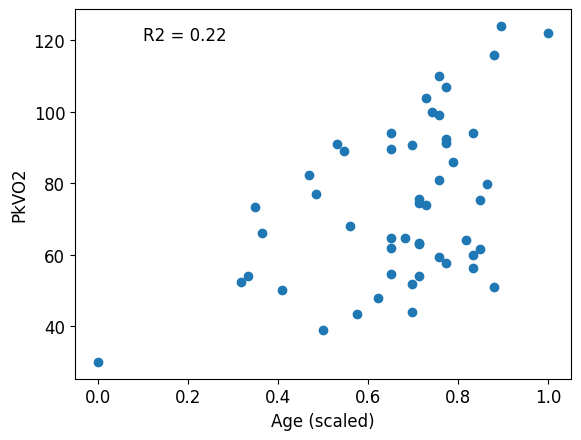

In [ ]:
predictor = combined_df['Age']
response = combined_df['pkvo2']
plt.scatter(predictor, response)
plt.xlabel('Age (scaled)', fontsize = 12)
plt.ylabel('PkVO2', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.text(0.1, 120, f'R2 = {round(pearsonr(predictor, response)[0]**2, 2)}', fontsize = 12)
plt.show()

In [ ]:
pairs = itertools.combinations(range(len(numerical_columns)), 2)

In [ ]:
correlated_pairs = []
for pair in list(pairs):
  if pearsonr(combined_df[numerical_columns[pair[0]]], combined_df[numerical_columns[pair[1]]])[0]**2 > 0.8:
    correlated_pairs.append(pair)

In [ ]:
len(correlated_pairs)

72

In [ ]:
remove_feats = set()
for pair in correlated_pairs:
  feat_1 = numerical_columns[pair[0]]
  feat_2 = numerical_columns[pair[1]]
  if feat_1 not in remove_feats:
    remove_feats.add(feat_1)

In [ ]:
len(remove_feats)

34

In [ ]:
reduced_df = combined_df.drop(columns = remove_feats)
reduced_df.head()

,patient_id,es_val_original_shape_LeastAxisLength,snr_original_shape_Sphericity,max_original_shape_MinorAxisLength,std_dev_original_shape_AxisRatios,std_dev_original_shape_SurfaceArea,min_original_shape_Maximum2DDiameterSlice,snr_original_shape_LeastAxisLength,std_dev_original_shape_Sphericity,mean_original_shape_Sphericity,...,Basophils,Absolute Neutrophils,Absolute Lymphocytes,Absolute Monocytes,Absolute Eosinophils,Absolute Basophils,Age:,Height (cm):,Weight (kg):,BMI
0,101B,0.343199,0.009091,0.837707,0.418263,0.649630,0.597291,0.207111,0.841834,0.088075,...,0.357143,0.068323,0.099905,0.277108,0.196970,0.250,0.733333,0.404255,0.312245,0.232509
1,103,0.856051,0.126506,0.909036,0.276324,0.239416,0.789193,1.000000,0.506450,0.705236,...,0.214286,0.030021,1.000000,0.192771,0.212121,0.125,0.377778,0.468085,1.000000,0.892617
2,105B,1.000000,0.518440,0.844678,0.103655,0.329838,0.965813,0.940873,0.114632,0.707463,...,0.500000,0.108696,0.071361,0.192771,0.348485,0.375,0.577778,0.787234,0.733673,0.444200
3,109,0.254331,0.116775,0.559832,0.082812,0.884718,0.311683,0.011551,0.507694,0.535893,...,0.214286,1.000000,0.104662,0.216867,0.015152,0.500,0.555556,0.276596,0.948980,1.000000
4,113B,0.096611,0.076313,0.244871,0.955686,0.736795,0.069454,0.000000,0.540228,0.000000,...,1.000000,0.128364,0.029496,0.265060,0.166667,0.750,0.755556,0.085106,0.265306,0.335454


In [ ]:
reduced_columns = list(reduced_df.columns)
reduced_columns.remove('pkvo2')
reduced_columns.remove('patient_id')

In [ ]:
pairs = itertools.combinations(range(len(reduced_columns)), 2)

In [ ]:
correlated_pairs = []
for pair in list(pairs):
  if pearsonr(reduced_df[reduced_columns[pair[0]]], reduced_df[reduced_columns[pair[1]]])[0]**2 > 0.8:
    correlated_pairs.append(pair)
len(correlated_pairs)

0

In [ ]:
# looking at features with high correlation with pkvo2
response = reduced_df['pkvo2']
numerical_columns = list(set(reduced_columns))
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(reduced_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
important_features_subset = [ent for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
for ent in important_features_subset:
  print(ent)

significant features: 
(feature name, R^2, p-value)

('Age', 0.223, 0.000467)
('skewness-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1', 0.161, 0.003556)
('skewness-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1', 0.142, 0.006441)
('kurtosis-Laws  S3L3L3', 0.137, 0.007581)
('skewness-Gradient z', 0.129, 0.009759)
('kurtosis-Laws  S3E3E3', 0.128, 0.009946)
('skewness-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1', 0.12, 0.012842)
('skewness-Laws  S3S3S3', 0.117, 0.013915)
('skewness-Gabor XY-θ=2.749, XZ-θ=2.356, λ=0.880, BW=1', 0.117, 0.014123)
('kurtosis-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1', 0.112, 0.016572)
('snr_original_shape_Sphericity', 0.109, 0.018132)
('kurtosis-Gabor XY-θ=0.785, XZ-θ=2.356, λ=0.880, BW=1', 0.109, 0.017756)
('kurtosis-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1', 0.102, 0.022355)


In [ ]:
def adj_r2_score(r2, k):
    '''
    calculates adjusted R2
    '''
    n = 51
    return 1. - ((1.-r2)*(n-1.)/(n-k-1))

In [ ]:
def cross_val_5fold(df_scaled, response, hand_selected_features):
    '''
    performs cross validation 100 times and returns the average and standard error of R^2 and RMSE scores
    '''
    features_subset = hand_selected_features
    X = df_scaled[features_subset]
    y = response
    # Number of random trials
    NUM_TRIALS = 20
    n_splits = 5

    lin_reg = LinearRegression()

    # Arrays to store scores
    val_r2_scores = np.zeros(NUM_TRIALS*n_splits)
    train_r2_scores = np.zeros(NUM_TRIALS*n_splits)
    # val_R_scores = np.zeros(NUM_TRIALS*n_splits)
    # train_R_scores = np.zeros(NUM_TRIALS*n_splits)
    val_rmse_scores = np.zeros(NUM_TRIALS*n_splits)
    train_rmse_scores = np.zeros(NUM_TRIALS*n_splits)
    coeffs = []
    intcepts = []

    for i in range(NUM_TRIALS):
        val_preds_per_trial = []

        cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)

        iteration = 0
        for train_ix, test_ix in cv.split(X,y):
            X_train, X_test = X.loc[train_ix, :], X.loc[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]

            lin_reg.fit(X_train, y_train)
            y_hat = lin_reg.predict(X_test)
            val_r2_scores[i*n_splits + iteration] = r2_score(y_test, y_hat)
            train_r2_scores[i*n_splits + iteration] = r2_score(y_train, lin_reg.predict(X_train))
            # val_R_scores[i*n_splits + iteration] = pearsonr(y_test, y_hat)[0]
            # train_R_scores[i*n_splits + iteration] = pearsonr(y_train, lin_reg.predict(X_train))[0]
            train_rmse_scores[i*n_splits + iteration] = mean_squared_error(y_test, y_hat, squared=False)
            val_rmse_scores[i*n_splits + iteration] = mean_squared_error(y_test, y_hat, squared=False)

            coeffs.append(lin_reg.coef_)
            intcepts.append(lin_reg.intercept_)
            iteration += 1
    sqrt_n = np.sqrt(NUM_TRIALS*n_splits)
    # print('validation R^2 scores:', round(val_r2_scores.mean(), 3), round(val_r2_scores.std()/sqrt_n, 2))
    # print('training scores:', round(train_r2_scores.mean(), 3), round(train_r2_scores.std()/sqrt_n, 2),'\n')

    return val_r2_scores.mean(), val_r2_scores.std()/sqrt_n,\
train_r2_scores.mean(), train_r2_scores.std()/sqrt_n,\
intcepts,coeffs,\
val_rmse_scores.mean(), val_rmse_scores.std()/sqrt_n,\
train_rmse_scores.mean(), train_rmse_scores.std()/sqrt_n


In [ ]:
def interesting_combos_func(df_scaled, numerical_columns, num_feat, shortlisted_features, interesting_combos):
    '''
    scans the feature space to find subsets of features with VIF < 5
    '''
    rem_feat = num_feat - len(shortlisted_features)
    rem_columns = list(copy.deepcopy(numerical_columns))
    for feat in shortlisted_features:
        rem_columns.remove(feat)

    for comb in itertools.combinations(rem_columns, rem_feat):
        important_features_subset = []
        important_features_subset = list(comb)
        important_features_subset.extend(shortlisted_features)
        X = df_scaled[important_features_subset].assign(const=1)
        vif_values = [vif(X.values, i) for i in range(num_feat)]
        if max(vif_values) <= 5.:
            vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
            interesting_combos.append(important_features_subset)
    return interesting_combos

def best_features_subset(df_scaled, response, interesting_combos):
    '''
    returns the best subset of features that has the maximum regression score
    '''
    max_reg = 0.
    multivariate_y = response
    for important_features_subset in interesting_combos:
        multivariate_x = df_scaled[important_features_subset]
        reg = LinearRegression().fit(multivariate_x, multivariate_y)
        reg_score = reg.score(multivariate_x, multivariate_y)
        if reg_score > max_reg:
            max_reg = reg_score
            max_reg_features = important_features_subset
    if interesting_combos == []: return [], 0.

    return max_reg_features, max_reg

In [ ]:
def best_subset_regression(initial_feature, df, y, numerical_columns, num_iters):
    '''
    performs best subset regression
    '''
    max_reg_features = initial_feature
    num_feat = len(max_reg_features)
    pkvo2_vals = y

    r2_scores_mean = []
    r2_scores_std = []
    num_feats = []

    for i in range(num_iters):
        num_feat += 1
        interesting_combos = []
        shortlisted_features =  max_reg_features
        #
        interesting_combos = interesting_combos_func(df, numerical_columns, num_feat, shortlisted_features, interesting_combos)
        print(num_feat, len(interesting_combos))
        #
        max_reg_features, max_reg = best_features_subset(df, pkvo2_vals, interesting_combos)
        if not max_reg_features == []:
            #
            val_r2_scores_mean, val_r2_scores_std,\
            train_r2_scores_mean, train_r2_scores_std,\
            intcepts,coeffs,\
            val_R_scores_mean, val_R_scores_std,\
            train_R_scores_mean, train_R_scores_std = cross_val_5fold(df, pkvo2_vals, max_reg_features)
            r2_scores_mean.append(val_r2_scores_mean)
            r2_scores_std.append(val_r2_scores_std)
        else:
            r2_scores_mean.append(0.)
            r2_scores_std.append(0.)
        num_feats.append(num_feat)
    return r2_scores_mean, r2_scores_std, num_feats, max_reg_features, intcepts,coeffs

In [ ]:
def random_combination(iterable, r):
    "Randomly selects a combination of r features"
    pool = tuple(iterable)
    n = len(pool)
    # print(n)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

In [ ]:
important_features_subset = [ent[0] for ent in important_features_subset]
important_features_subset

['Age',
 'skewness-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1',
 'skewness-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1',
 'kurtosis-Laws  S3L3L3',
 'skewness-Gradient z',
 'kurtosis-Laws  S3E3E3',
 'skewness-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1',
 'skewness-Laws  S3S3S3',
 'skewness-Gabor XY-θ=2.749, XZ-θ=2.356, λ=0.880, BW=1',
 'kurtosis-Gabor XY-θ=2.356, XZ-θ=0.785, λ=0.880, BW=1',
 'snr_original_shape_Sphericity',
 'kurtosis-Gabor XY-θ=0.785, XZ-θ=2.356, λ=0.880, BW=1',
 'kurtosis-Gabor XY-θ=2.356, XZ-θ=2.356, λ=0.880, BW=1']

In [ ]:
interesting_combos = interesting_combos_func(reduced_df, important_features_subset, 6, [], [])

In [ ]:
len(interesting_combos)

1581

In [ ]:
def vif_calculator(df_scaled, feats):
  num_feat = len(feats)
  X = df_scaled[feats].assign(const=1)
  vif_values = [vif(X.values, i) for i in range(num_feat)]
  if max(vif_values) <= 5.:
    return True
  else:
    return False

In [ ]:
c = 0
interesting_combos_list = []
while c < 100:
  comb = random_combination(range(len(reduced_columns)), 6)
  feats = [reduced_columns[i] for i in comb]
  if vif_calculator(reduced_df, feats):
    interesting_combos_list.append(feats)
    c += 1

In [ ]:
# Making a list of single classifiers
estimators = {'linreg': LinearRegression(),
'svm': svm.SVR(),
'rf': RandomForestRegressor(),
'gbr': GradientBoostingRegressor(),
'xgbr': XGBRegressor()
}

In [ ]:
scoring = {
          'r2': 'r2',
          'rmse': 'neg_root_mean_squared_error'
          }

In [ ]:
# creating grid serach parameters for each single model.
param_grid = {
    'linreg':
    {},

    'svm':
    {'C': [0.1, 1., 10.]},

    'rf':
    {'max_depth': [1, 5],
     'min_samples_leaf': [1, 5],
     'n_estimators': [50, 100, ]},

    'gbr': {'max_depth': [1, 5],
            'min_samples_leaf': [1,5]},

      'xgbr': {'max_depth': [1, 5],
               'learning_rate': [0.1, 1.],},
    }

In [ ]:
y = reduced_df['pkvo2'].values

In [ ]:
def best_scores_function(estimator, df, model_r2_dict, model_rmse_dict):
  '''
  The function sets up and performs grid search cv for any of the 8 models.
  Args: estimator: single/ensemble estimator
        df: dataframe containing features and target
        model_r2_dict: dictionary containing r2 scores
        model_rmse_dict: dictionary containing RMSE scores
  Returns:
        model_r2_dict: dictionary containing updated r2 scores
        model_rmse_dict: dictionary containing updated RMSE scores
  '''
  # Check if the estimator is a single estimator or an ensemble estimator
  est = estimators[estimator]
  # setting up grid search cv parameters for single models
  grid_search = GridSearchCV(est, param_grid[estimator], cv = 5, scoring = scoring, refit=False, n_jobs=-1)

  start = time.time()
  # Fit the grid search based on the estimator type

  grid_search.fit(df, y);
  # print(f'{estimator} Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

  # grid search cv results
  est_scores = grid_search.cv_results_
  # Update the model F1 score dictionary with the maximum F1 score
  model_rmse_dict[estimator] = min(abs(est_scores['mean_test_rmse']))
  max_rmse_index = np.argsort(abs(est_scores['mean_test_rmse']))[0]
  # model_rmse_dict[estimator] = max(est_scores['mean_test_rmse'])
  # max_rmse_index = np.argsort(est_scores['mean_test_rmse'])[::-1][0]
  # Update the model accuracy dictionary with the accuracy corresponding to the maximum F1 score
  model_r2_dict[estimator] = est_scores['mean_test_r2'][max_rmse_index]

  return model_r2_dict, model_rmse_dict

In [ ]:
df = reduced_df[interesting_combos_list[0]]
df.head()

,max_original_shape_MinorAxisLength,snr_original_shape_LeastAxisLength,lvmc_avg_convexity_y,lv_avg_convexity_y,skewness-Gradient z,MCHC
0,0.837707,0.207111,0.430914,0.446254,1.000000,0.60
1,0.909036,1.000000,0.205140,0.370768,0.894000,0.32
2,0.844678,0.940873,0.122505,0.307613,0.647365,0.66
3,0.559832,0.011551,0.445041,0.495318,0.760632,0.40
4,0.244871,0.000000,0.726012,1.000000,0.597333,0.60


In [ ]:
model_r2_dict = {}
model_rmse_dict = {}

In [ ]:
r2_scores = []
rmse_scores = []
r2_dict, rmse_dict = {}, {}
est = 'linreg'
for combo in interesting_combos_list:
    df = combined_df[combo]
    r2_dict, rmse_dict = best_scores_function(est, df ,r2_dict, rmse_dict)
    r2_scores.append(r2_dict[est])
    rmse_scores.append(rmse_dict[est])

# best_model_index = np.argsort(r2_scores)[-1]
# model_r2_dict['linreg'] = r2_scores[best_model_index]
# model_rmse_dict['linreg'] = rmse_scores[best_model_index]
model_r2_dict[est] = r2_scores
model_rmse_dict[est] = rmse_scores

In [ ]:
r2_scores = []
rmse_scores = []
r2_dict, rmse_dict = {}, {}
est = 'svm'
for combo in interesting_combos_list:
    df = combined_df[combo]
    r2_dict, rmse_dict = best_scores_function(est, df ,r2_dict, rmse_dict)
    r2_scores.append(r2_dict[est])
    rmse_scores.append(rmse_dict[est])
# best_model_index = np.argsort(r2_scores)[-1]
# model_r2_dict[est] = r2_scores[best_model_index]
# model_rmse_dict[est] = rmse_scores[best_model_index]
model_r2_dict[est] = r2_scores
model_rmse_dict[est] = rmse_scores

In [ ]:
r2_scores = []
rmse_scores = []
r2_dict, rmse_dict = {}, {}
est = 'rf'
for combo in interesting_combos_list:
    df = combined_df[combo]
    r2_dict, rmse_dict = best_scores_function(est, df ,r2_dict, rmse_dict)
    r2_scores.append(r2_dict[est])
    rmse_scores.append(rmse_dict[est])
# best_model_index = np.argsort(r2_scores)[-1]
# model_r2_dict[est] = r2_scores[best_model_index]
# model_rmse_dict[est] = rmse_scores[best_model_index]
model_r2_dict[est] = r2_scores
model_rmse_dict[est] = rmse_scores

In [ ]:
r2_scores = []
rmse_scores = []
r2_dict, rmse_dict = {}, {}
est = 'gbr'
for combo in interesting_combos_list:
    df = combined_df[combo]
    r2_dict, rmse_dict = best_scores_function(est, df ,r2_dict, rmse_dict)
    r2_scores.append(r2_dict[est])
    rmse_scores.append(rmse_dict[est])
# best_model_index = np.argsort(r2_scores)[-1]
# model_r2_dict[est] = r2_scores[best_model_index]
# model_rmse_dict[est] = rmse_scores[best_model_index]
model_r2_dict[est] = r2_scores
model_rmse_dict[est] = rmse_scores

In [ ]:
r2_scores = []
rmse_scores = []
r2_dict, rmse_dict = {}, {}
est = 'xgbr'
for combo in interesting_combos_list:
    df = combined_df[combo]
    r2_dict, rmse_dict = best_scores_function(est, df ,r2_dict, rmse_dict)
    r2_scores.append(r2_dict[est])
    rmse_scores.append(rmse_dict[est])
# best_model_index = np.argsort(r2_scores)[-1]
# model_r2_dict[est] = r2_scores[best_model_index]
# model_rmse_dict[est] = rmse_scores[best_model_index]
model_r2_dict[est] = r2_scores
model_rmse_dict[est] = rmse_scores

In [ ]:
best_r2_models = []
best_rmse_models = []

for ind in range(100):
  linreg_r2_score = model_r2_dict['linreg'][ind]
  svm_r2_score = model_r2_dict['svm'][ind]
  gbr_r2_score = model_r2_dict['gbr'][ind]
  xgbr_r2_score = model_r2_dict['xgbr'][ind]

  linreg_rmse_score = model_rmse_dict['linreg'][ind]
  svm_rmse_score = model_rmse_dict['svm'][ind]
  gbr_rmse_score = model_rmse_dict['gbr'][ind]
  xgbr_rmse_score = model_rmse_dict['xgbr'][ind]

  best_r2_model_index = np.argsort([linreg_r2_score, svm_r2_score, gbr_r2_score, xgbr_r2_score])[-1]
  best_r2_models.append(best_r2_model_index)

  best_rmse_model_index = np.argsort([linreg_rmse_score, svm_rmse_score, gbr_rmse_score, xgbr_rmse_score])[-1]
  best_rmse_models.append(best_rmse_model_index)

In [ ]:
for est in model_r2_dict.keys():
  print(est, max(model_r2_dict[est]))
print('***')
for est in model_rmse_dict.keys():
  print(est, min(model_rmse_dict[est]))

linreg 0.23148437196559152
svm 0.09167149663566217
rf 0.04176963048610176
gbr 0.0042171959491885905
xgbr -0.02955251936332881
***
linreg 18.0465336327827
svm 19.959410497119087
rf 19.47108552509456
gbr 19.977437336941755
xgbr 19.786579252892437


In [ ]:
def search_interesting_combos(num_feats):
  c = 0
  interesting_combos_list = []
  while c < 100:
    comb = random_combination(range(len(reduced_columns)),num_feats)
    feats = [reduced_columns[i] for i in comb]
    if vif_calculator(reduced_df, feats):
      interesting_combos_list.append(feats)
      c += 1
  return interesting_combos_list

In [ ]:
training_mean_r2_scores = {}
training_mean_rmse_scores = {}
validation_mean_r2_scores = {}
validation_mean_rmse_scores = {}
for num_feats in range(1,10):
  val_r2_scores_mean_list, val_rmse_scores_mean_list, train_r2_scores_mean_list, train_rmse_scores_mean_list = [], [], [], []
  interesting_combos_list = search_interesting_combos(num_feats)
  # print(num_feats, len(interesting_combos_list))
  for combo in interesting_combos_list:
    val_r2_scores_mean, _, train_r2_scores_mean, _, \
    _, _, val_rmse_scores_mean, _, train_rmse_scores_mean, \
    _ = cross_val_5fold(reduced_df, response, combo)

    val_rmse_scores_mean_list.append(val_rmse_scores_mean)
    val_r2_scores_mean_list.append(val_r2_scores_mean)
    train_rmse_scores_mean_list.append(train_rmse_scores_mean)
    train_r2_scores_mean_list.append(train_r2_scores_mean)

  training_mean_r2_scores[num_feats] = train_r2_scores_mean_list
  training_mean_rmse_scores[num_feats] = train_rmse_scores_mean_list
  validation_mean_r2_scores[num_feats] = val_r2_scores_mean_list
  validation_mean_rmse_scores[num_feats] = val_rmse_scores_mean_list
  print(num_feats)

1
2
3
4
5
6
7
8
9


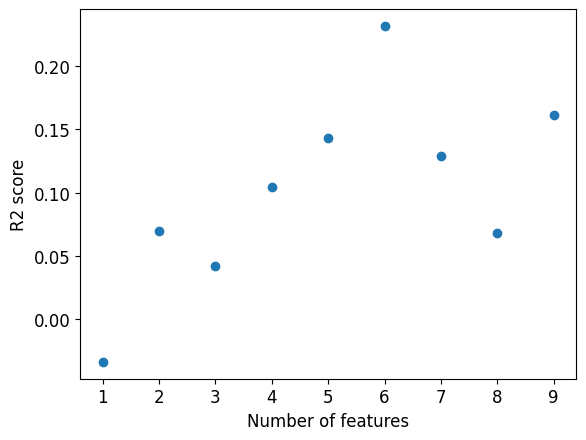

In [ ]:
y = [max(validation_mean_r2_scores[i]) for i in range(1,10)]
plt.scatter(range(1,10), y)
plt.xlabel('Number of features', fontsize = 12)
plt.ylabel('R2 score', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
# plt.scatter(range(1,10), [max(training_mean_r2_scores[i]) for i in range(1,10)])

In [ ]:
# iteratively increasing the feature subset by allowing one more feature in each iteration.
# let's start with height since it has the highest correlation with PkVO2
initial_feature = ['Age']
r2_scores_mean, r2_scores_std, num_feats, max_reg_features, intcepts, coeffs = \
best_subset_regression(initial_feature, reduced_df, response.values, reduced_columns, 5)

2 70
3 69
4 68
5 67
6 65


In [ ]:
# looking at features with the best R^2 score
max_reg_features

['lvmc_avg_Hausdorff_Dimension_x',
 'std_dev_original_shape_AxisRatios',
 'mean_original_shape_Sphericity',
 'skewness-Gradient z',
 'skewness-Laws  S3S3S3',
 'Age']

In [ ]:
model = best_subset_linreg(support_size=6)
model.fit(reduced_df[reduced_columns], response)

LinearRegression(support_size=6)

In [ ]:
for ind in range(len(reduced_columns)):
  if model.coef_[ind] != 0.:
    print(reduced_columns[ind], model.coef_[ind])


std_dev_original_shape_AxisRatios 30.962050601202826
mean_original_shape_Sphericity 32.77944978079851
lvmc_std_average_radial_ratio_y -17.498180100353657
kurtosis-Laws  S3L3L3 -35.92779902740286
skewness-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1 43.01330933668187
Age 42.56979590891056


In [ ]:
# verifying that the features are uncorrelated
X = reduced_df[max_reg_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(max_reg_features))]
vif_feat_vals = {max_reg_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

std_dev_original_shape_AxisRatios 1.219
mean_original_shape_Sphericity 1.152
skewness-Gradient z 1.104
skewness-Laws  S3S3S3 1.085
lvmc_avg_Hausdorff_Dimension_x 1.056
Age 1.016


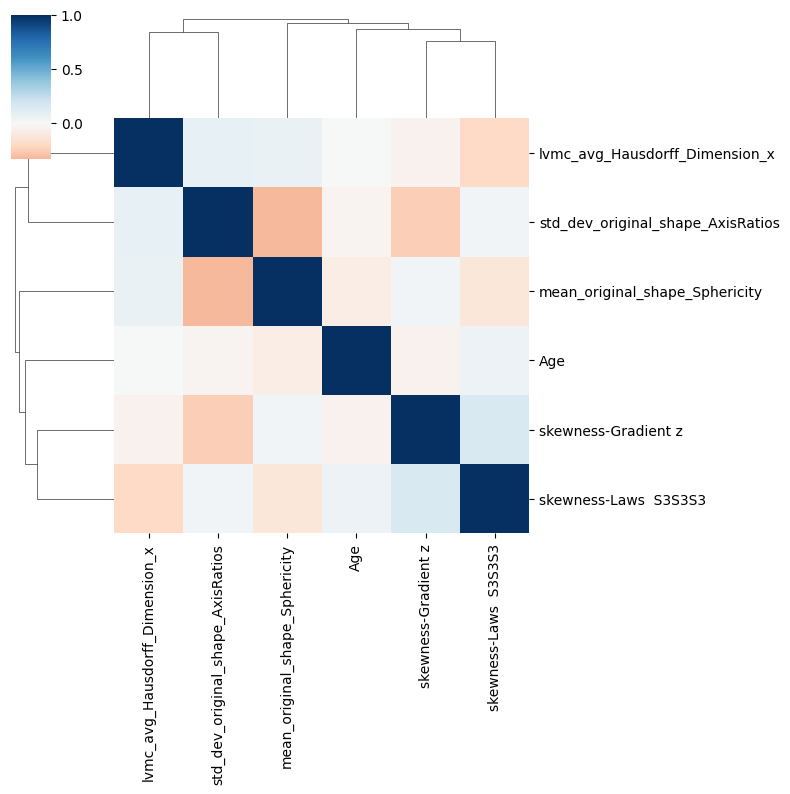

In [ ]:
# verifying that the features are uncorrelated
sns.clustermap(reduced_df[max_reg_features].corr(),cmap = 'RdBu', center = 0.0, figsize=(8,8));

In [ ]:
coeffs_1 = [ent[5] for ent in coeffs]
np.mean(coeffs_1)

61.83993043146595

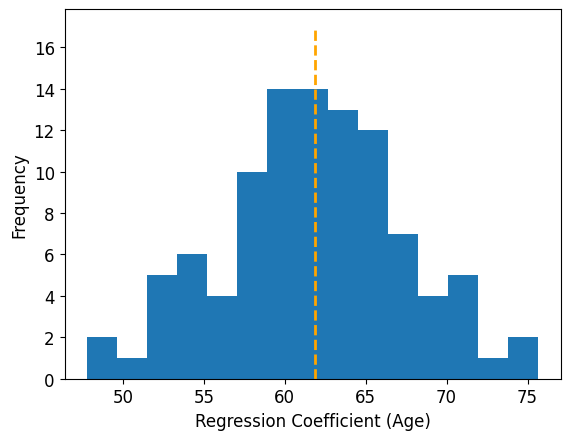

In [ ]:
plt.hist(coeffs_1, bins=15)
plt.xlabel('Regression Coefficient (Age)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.vlines(np.mean(coeffs_1), 0, 17, color = 'orange', ls = '--', lw = 2);

In [ ]:
# calculating mean of coefficients and intercept
mean_coeffs = np.mean(coeffs,axis=0)
mean_intcept = np.mean(intcepts,axis=0)

In [ ]:
# looking at the most important features
abs_mean_coeffs = abs(mean_coeffs)
abs_mean_coeffs_args = np.argsort(abs_mean_coeffs)
print('(features, coefficient)')
[(max_reg_features[i], round(mean_coeffs[i],3)) for i in abs_mean_coeffs_args[::-1]]

(features, coefficient)


[('Age', 61.84),
 ('mean_original_shape_Sphericity', 29.768),
 ('skewness-Laws  S3S3S3', -29.169),
 ('skewness-Gradient z', -28.846),
 ('std_dev_original_shape_AxisRatios', 21.878),
 ('lvmc_avg_Hausdorff_Dimension_x', 17.62)]

In [ ]:
def average_model_predictions(df, features, y, coeffs, intercepts):
    '''
    returns predictions from average model of 100 iterations
    '''
    mean_coeffs = np.mean(coeffs,axis=0)
    mean_coeffs = np.array(mean_coeffs).reshape((mean_coeffs.shape[0],1))
    mean_intcept = np.mean(intercepts,axis=0)
    X = df[features]
    ans = np.matmul(X, mean_coeffs)

    ground_truth = y
    feat_x_X = np.matmul(X, mean_coeffs)
    mean_response = feat_x_X + mean_intcept

    return mean_response.values


In [ ]:
# making predictions from the average model
ground_truth = response.values
predicted = average_model_predictions(reduced_df, max_reg_features, \
                                      ground_truth, coeffs, intcepts)

In [ ]:
# calculating R^2 score of average model
print('R^2 score =', round(r2_score(ground_truth, predicted),2))

R^2 score = 0.6


In [ ]:
ground_truth = response.values.reshape((len(response.values),1))

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(ground_truth, predicted)

LinearRegression()

In [ ]:
coef = lin_reg.coef_[0][0]
coef

0.6041835629343185

In [ ]:
intcpt = lin_reg.intercept_[0]
intcpt

29.300464328359368

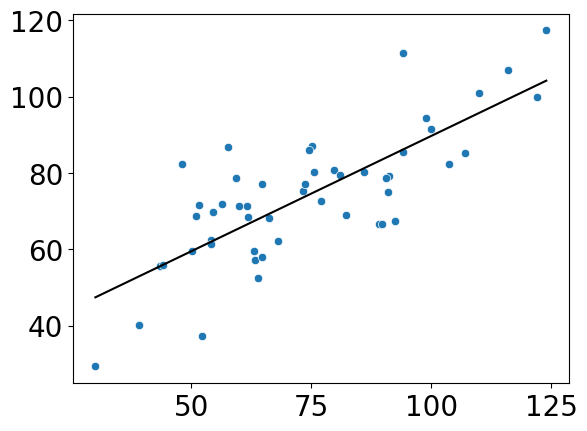

In [ ]:
# ax = sns.regplot(x=ground_truth, y=predicted, ci=95)
ax = sns.scatterplot(x=[ent[0] for ent in ground_truth], y=[ent[0] for ent in predicted])
xs = np.linspace(min(ground_truth), max(ground_truth), 100)
# ax.scatter(ground_truth, predicted)
ax.plot(xs, xs*coef + intcpt, c='black')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig(f'{csv_path}/scatter_plot_combined.png')